In [1]:
import multiprocessing
import threading
import vio_ort
import json
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
lat_VIO = []
lon_VIO = []

odometry = vio_ort.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
#set_dir = '2025_1_16_15_43_35'
#set_dir = '2024_12_15_15_18_8_num_24'
set_dir = '2024_12_15_15_31_8_num_3'
#set_dir = '2024_12_15_15_31_8_num_5'

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

In [3]:
# Iterate over files in the dataset directory
for filename in json_files[start:start + count_json]:
    # Read the JSON file
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data:
            if data['GNRMC']['status'] == 'A':
                img_path = set_dir + '/' + os.path.splitext(filename)[0] + '.jpg'
                
                # Проверяем существование файла изображения
                if not os.path.exists(img_path):
                    print(f"Image not found: {img_path}. Skipping...")
                    continue
                
                image = cv2.imread(img_path)
                
                # Проверяем, удалось ли загрузить изображение
                if image is None:
                    print(f"Failed to load image: {img_path}. Skipping...")
                    continue

                # Обработка изображения
                try:
                    result_vio = odometry.add_trace_pt(image, data)
                except Exception as e:
                    print(f"Error processing image: {img_path}. Skipping... Error: {e}")
                    continue
                
                # Добавляем результаты в списки
                lat_VIO.append(result_vio['lat'])
                lon_VIO.append(result_vio['lon'])
                lat_GPS.append(data['GNRMC']['lat'])
                lon_GPS.append(data['GNRMC']['lon'])

In [4]:
def process_file_threaded(filename):
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return
            
            image = cv2.imread(img_path)
            if image is None:
                return
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                with threading.Lock():
                    lat_VIO.append(result_vio['lat'])
                    lon_VIO.append(result_vio['lon'])
                    lat_GPS.append(data['GNRMC']['lat'])
                    lon_GPS.append(data['GNRMC']['lon'])
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Запускаем обработку в потоках
threads = []
for filename in json_files[start:start + count_json]:
    thread = threading.Thread(target=process_file_threaded, args=(filename,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


In [5]:
# print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

VIO lat: 54.889668


In [6]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257321667
VIO lon: 83.1258973333


In [7]:
print(len(lat_GPS))
print(len(lat_VIO))

1064
1064


Latitude VIO [54.889668, 54.88966799965247, 54.88966799987664, 54.88966799579814, 54.88966799658628, 54.889667991892615, 54.88966799546007, 54.88966799467335, 54.88966799486639, 54.889667994407716, 54.88966799455823, 54.889667995163244, 54.889667995281364, 54.889667994840266, 54.88966799513626, 54.889667994992344, 54.889667995964835, 54.88966799499835, 54.88966799505549, 54.88966799545411, 54.88966799505334, 54.88966799522489, 54.88966799535479, 54.889667995374154, 54.88966799495024, 54.88966799557845, 54.88966799542744, 54.88966799533356, 54.889667995327166, 54.8896679955274, 54.889667995359936, 54.88966799541806, 54.889667995482554, 54.88966799530773, 54.88966799572223, 54.8896679955301, 54.88966799556094, 54.8896679956208, 54.88966799565009, 54.88966799547456, 54.88966799570822, 54.88966799555889, 54.889667995701764, 54.88966799582452, 54.88966799568529, 54.88966799599349, 54.88966799598569, 54.889667995908056, 54.889667995887336, 54.8896679962978, 54.88966799609214, 54.889667995889

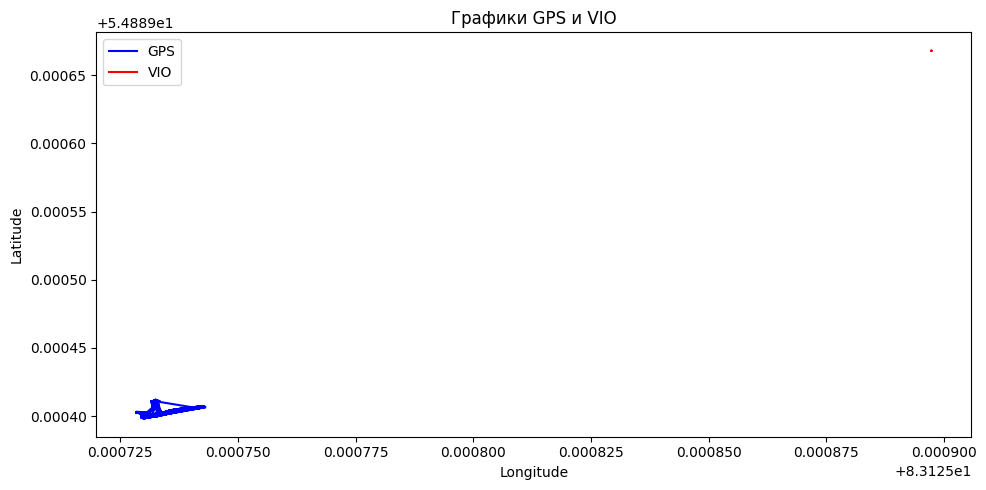

In [8]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

print('Latitude VIO', copy_lat_VIO)
print('Longitude VIO', copy_lon_VIO)

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

print('Latitude GPS', copy_lat_GPS)
print('Longitude GPS', copy_lon_GPS)

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

print('Another Latitude GPS', copy_lat_GPS)

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

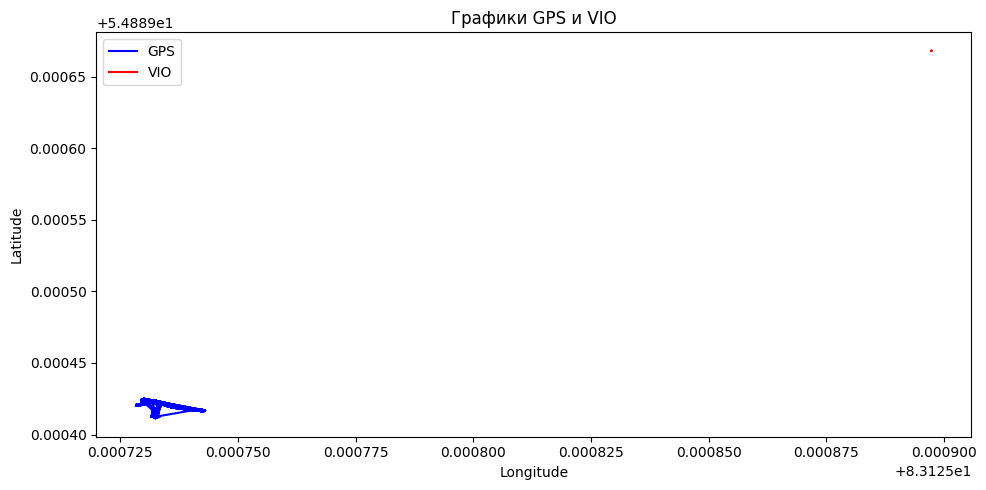

In [9]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()